# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [8]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv",delimiter=';')
# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv",delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('azdias has {} rows and {} columns'.format(*azdias.shape))
print('feat_info has {} rows and {} columns'.format(*feat_info.shape))

azdias.head(2)



azdias has 891221 rows and 85 columns
feat_info has 85 rows and 4 columns


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0


In [4]:
feat_info.head(2)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
azdias_copy=pd.DataFrame(data=azdias,copy=True)#this is a copy to get rid of its nulls
azdias_copy.isnull().sum()# null count are obvious in each column

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [6]:
#to replace the null tags to np.nan
feat_info.set_index('attribute', inplace=True)

In [ ]:
for col_name in azdias_copy.columns:
    azdias_copy[col_name] = azdias_copy[col_name].map(lambda x: np.nan if str(x) in feat_info.loc[col_name].missing_or_unknown else x)
azdias_copy.to_csv('azdias_2.csv', sep=';', index = False) #this takes long time, thats why I stored it 


In [9]:
azdias2 = pd.read_csv("azdias_2.csv",delimiter=';')#reading the file because previous step is timely

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
initial_nulls=pd.Series(index=azdias.columns, data=(azdias.isnull().sum() / azdias.size) * 100)# initial nulls


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [9]:
#initial count of NaN in the data
initial_nulls=pd.Series(index=azdias.columns, data=(azdias.isnull().sum() / azdias.shape[0]) * 100)
initial_nulls# % of the the nulls


AGER_TYP                  0.000000
ALTERSKATEGORIE_GROB      0.000000
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR               0.000000
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP                0.000000
LP_LEBENSPHASE_FEIN       0.544646
LP_LEBENSPHASE_GROB       0.544646
LP_FAMILIE_FEIN           0.544646
LP_FAMILIE_GROB           0.544646
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ          0.000000
PRAEGENDE_JUGENDJAHRE     0.000000
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset. note that this is on azadias2
secondary_nulls=pd.Series(index=azdias2.columns, data=(azdias2.isnull().sum() / azdias2.shape[0]) * 100)
secondary_nulls



AGER_TYP                 85.909668
ALTERSKATEGORIE_GROB     16.355988
ANREDE_KZ                47.790167
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST        15.662445
FINANZ_SPARER            28.075303
FINANZ_VORSORGER         11.710788
FINANZ_ANLEGER           23.654290
FINANZ_UNAUFFAELLIGER    24.752222
FINANZ_HAUSBAUER         16.057072
FINANZTYP                22.393099
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               30.697661
LP_LEBENSPHASE_FEIN       0.544646
LP_LEBENSPHASE_GROB       0.544646
LP_FAMILIE_FEIN           0.544646
LP_FAMILIE_GROB           0.544646
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         88.911729
PRAEGENDE_JUGENDJAHRE    14.524568
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 6.966622
SEMIO_FAM                 9.191435
SEMIO_REL                12.132793
SEMIO_MAT                10.922207
SEMIO_VERT          

AGER_TYP                 85.909668
ANREDE_KZ                47.790167
FINANZ_SPARER            28.075303
FINANZ_ANLEGER           23.654290
FINANZ_UNAUFFAELLIGER    24.752222
FINANZTYP                22.393099
GEBURTSJAHR              44.020282
HEALTH_TYP               30.697661
NATIONALITAET_KZ         88.911729
SHOPPER_TYP              41.062430
VERS_TYP                 55.261153
KK_KUNDENTYP             65.596749
dtype: float64

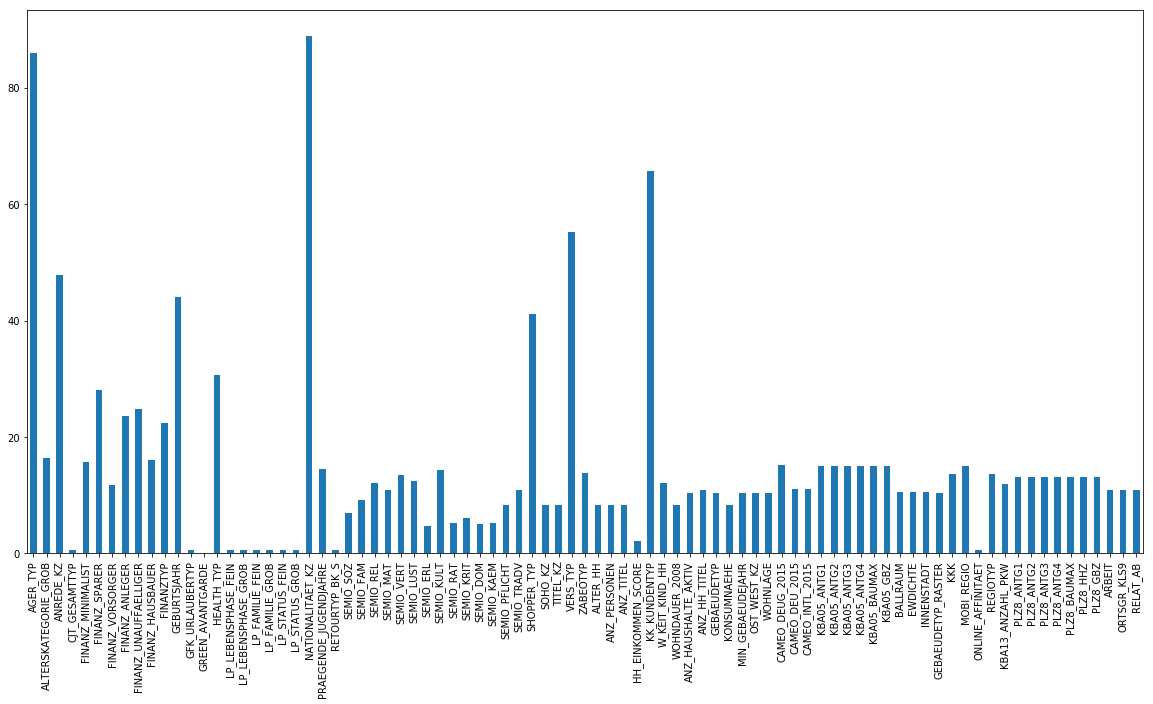

In [10]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
all_nulls=pd.Series(index=azdias2.columns, data=(azdias2.isnull().sum() / azdias2.shape[0]) * 100)
all_nulls.plot.bar(figsize=(20,10))
#finding outlier columns that have more than 20% null values, we can remove more than 10 % as well but we will 
#miss majarity of our data
all_nulls[all_nulls>20]



In [11]:
out_columns=all_nulls[all_nulls>20].keys()
print(out_columns)
azdias2.drop(out_columns, axis=1, inplace=True)



Index(['AGER_TYP', 'ANREDE_KZ', 'FINANZ_SPARER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZTYP', 'GEBURTSJAHR', 'HEALTH_TYP',
       'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'KK_KUNDENTYP'],
      dtype='object')


In [15]:
azdias2.shape

(891221, 73)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

Text(0.5,1,'shows hitogram of the missing data')

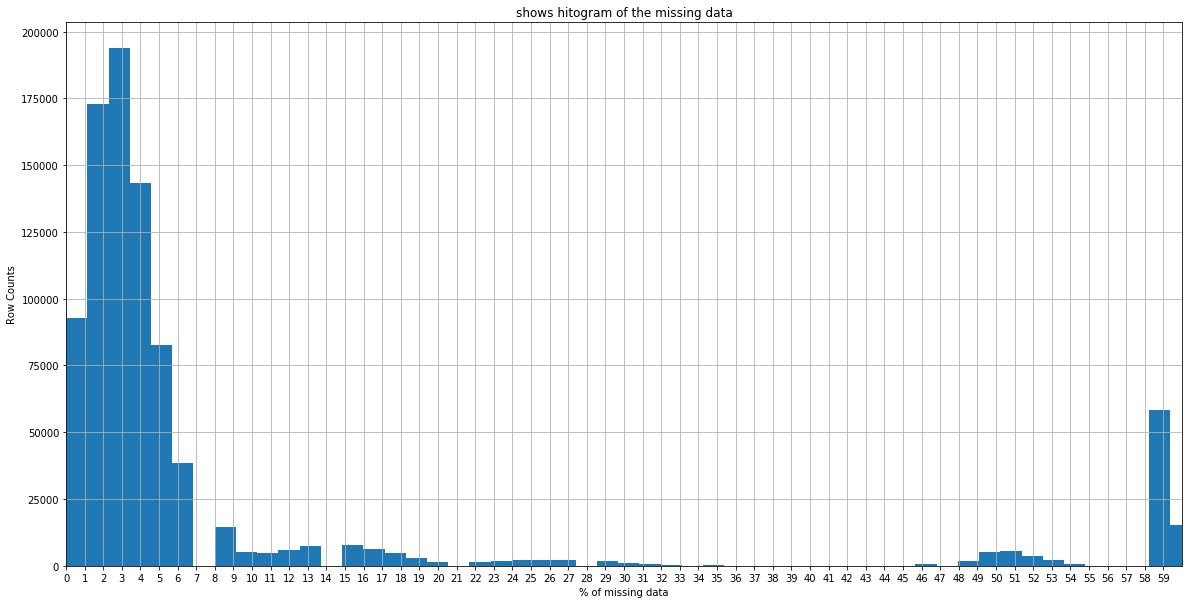

In [16]:
# How much data is missing in each row of the dataset?

(100*(azdias2.shape[1]-azdias2.count(axis=1))/azdias2.shape[1]).to_frame().hist(figsize=(20,10),bins=60)  # to find % of nulls in the rows
plt.xticks(np.arange(60));
plt.xlim(0,60)
plt.ylabel('Row Counts')
plt.xlabel('% of missing data')
plt.title('shows hitogram of the missing data')

In [12]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row. 
#we will divde the data that more than 3 enteries is null. 3 divides the data to almosr 2 equal count

fair = azdias2[azdias2.isnull().sum(axis=1) < 3].reset_index(drop=True)
poor = azdias2[azdias2.isnull().sum(axis=1) >= 3].reset_index(drop=True)
fair.shape
poor.shape

(431815, 73)

In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
data_diff=poor.count(axis=0)-fair.count(axis=0)
first_3good_last3_poor=pd.concat([data_diff.sort_values().head(3),data_diff.sort_values().tail(3)])
first_3good_last3_poor

KBA05_ANTG4           -160915
KBA05_GBZ             -160915
KBA05_ANTG3           -160915
LP_LEBENSPHASE_FEIN    -32445
SEMIO_LUST             -29963
GREEN_AVANTGARDE       -27591
dtype: int64

KBA05_ANTG4
KBA05_GBZ
KBA05_ANTG3
LP_LEBENSPHASE_FEIN
SEMIO_LUST
GREEN_AVANTGARDE


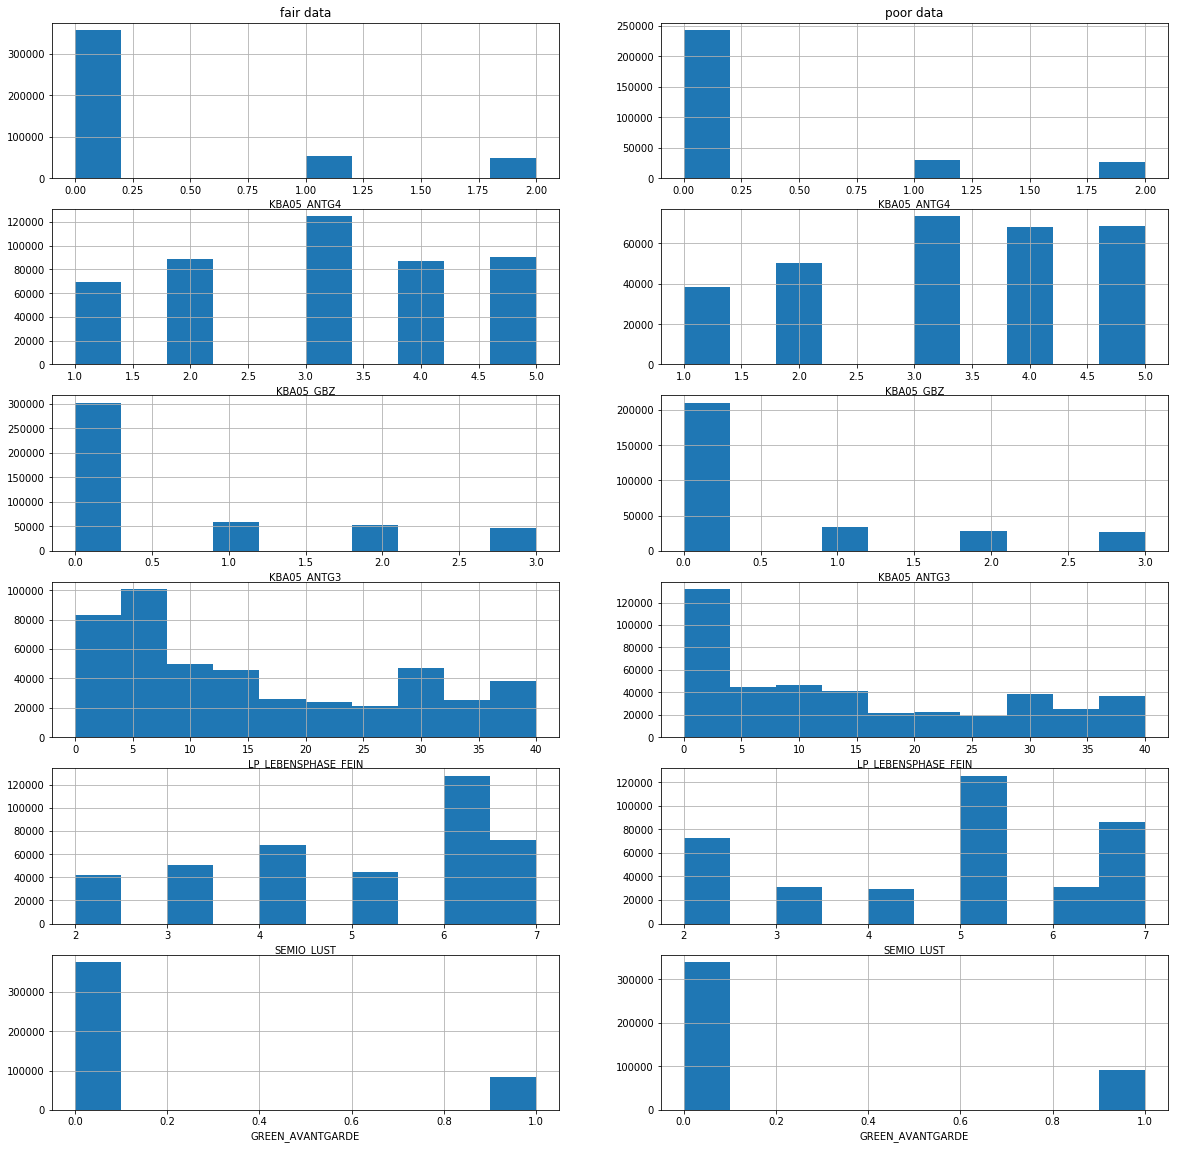

In [19]:
plt.figure(figsize=(20,20))
num=0
for i in range(1,12,2):
    plt.subplot(6,2,i)
    col_name=first_3good_last3_poor.index[num]
    print(col_name)
    fair[col_name].hist()
    if i==1:
        plt.title('fair data')
    plt.xlabel(col_name)

    plt.subplot(6,2,i+1)
    poor[col_name].hist()
    if i==1:
        plt.title('poor data')
    plt.xlabel(col_name)
    num+=1

In [3]:

#we might also think about using some sort of statistical hypothesis test here as well. You might 
#check out using a Kolmogorov–Smirnov test to test each column against the null hypothesis. 


In [13]:
from scipy.stats import ks_2samp
comp_df = pd.DataFrame(azdias2.columns, columns=['col'])
def hypothesis_test(df1, df2, cols):
    stats = []
    pvalues = []
    for col in cols:
        counts_main = df1[col].value_counts().sort_index()
        counts_drop = df2[col].value_counts().sort_index()
        try:
            ch = ks_2samp(counts_main, counts_drop)
            stats.append(ch.statistic)
            pvalues.append(ch.pvalue)
        except:
            stats.append(np.nan)
            pvalues.append(np.nan)

    return stats, pvalues

stats, pvalues = hypothesis_test(poor, fair, poor.columns)
comp_df['stats'] = stats
comp_df['pvalues'] = pvalues
comp_df.head()

,col,stats,pvalues
0,ALTERSKATEGORIE_GROB,0.333333,0.976213
1,CJT_GESAMTTYP,0.166667,0.999957
2,FINANZ_MINIMALIST,0.500000,0.534416
3,FINANZ_VORSORGER,0.250000,0.996876
4,FINANZ_HAUSBAUER,0.500000,0.534416


#### Discussion 1.1.3: Assess Missing Data in Each Row

the first 3 rows(least difference between data count between same column in poor and fair data) are simmilar to the disturbytion of a column between poor and fair data set. Reason is obvious because it looks like that we randomly picked two sample sets from same population. Eaven if data counts are different in two sample sets, but they are mimicing same parent population.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [20]:
feat_info2=feat_info.copy()

In [21]:
feat_info2.shape

(85, 3)

In [22]:
feat_info2.drop(out_columns, axis=0,inplace=True)

In [23]:
# How many features are there of each data type?
feat_info2.groupby(['type'])['information_level'].count()

type
categorical    14
interval        1
mixed           7
numeric         6
ordinal        45
Name: information_level, dtype: int64

In [24]:
# How many features are there of each data type? this is before removing out_columns
feat_info.groupby(['type'])['information_level'].count()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: information_level, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [25]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_columns=feat_info2[feat_info2['type']=='categorical'].index
azdias2[cat_columns].nunique()


CJT_GESAMTTYP        6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     12
LP_FAMILIE_GROB      6
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
SOHO_KZ              2
TITEL_KZ             6
ZABEOTYP             5
GEBAEUDETYP          7
OST_WEST_KZ          2
CAMEO_DEUG_2015      8
CAMEO_DEU_2015      44
dtype: int64

In [26]:
# hear we compare the catagories with the data that we are going to predict, we want to make sure that we are dealing with simmilar data
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
diff=customers[cat_columns].nunique()-azdias2[cat_columns].nunique()
diff!=0
#there are 5 features that are having different lables in training and data for predicting

CJT_GESAMTTYP       False
GFK_URLAUBERTYP     False
GREEN_AVANTGARDE    False
LP_FAMILIE_FEIN     False
LP_FAMILIE_GROB     False
LP_STATUS_FEIN      False
LP_STATUS_GROB      False
SOHO_KZ             False
TITEL_KZ             True
ZABEOTYP             True
GEBAEUDETYP          True
OST_WEST_KZ         False
CAMEO_DEUG_2015      True
CAMEO_DEU_2015       True
dtype: bool

In [27]:
# here we see that not all the columns has the same number of fetures. This might be for a good reason, but since we are not familiare 
#with the data , safest would be to remove these columns altogether. This is important because if we do One_Hot_Encoding
#then we wont end up with the same number of columns which means that we cant come use our model to predict Customers data
out2_columns=diff[diff!=0].index
out2_columns

Index(['TITEL_KZ', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015',
       'CAMEO_DEU_2015'],
      dtype='object')

In [28]:
azdias2.drop(out2_columns, axis=1, inplace=True)
azdias2.shape

(891221, 68)

In [29]:
feat_info2.drop(out2_columns, axis=0,inplace=True)

In [30]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_columns=feat_info2[feat_info2['type']=='categorical'].index
azdias2[cat_columns].nunique()

CJT_GESAMTTYP        6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     12
LP_FAMILIE_GROB      6
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
SOHO_KZ              2
OST_WEST_KZ          2
dtype: int64

In [31]:
# now select the columns with just two catagories
a=pd.DataFrame(azdias2[cat_columns].nunique()==2,columns=['binary'])
col_binary=a[a['binary']==True].index
azdias2[col_binary]

,GREEN_AVANTGARDE,SOHO_KZ,OST_WEST_KZ
0,0,NaN,NaN
1,0,1.0,W
2,1,0.0,W
3,0,0.0,W
4,0,0.0,W
5,0,0.0,W
6,0,0.0,W
7,0,0.0,W
8,1,0.0,W
9,1,0.0,W


In [32]:
#we wouldnt need this cause we are doing OHC later too
azdias2['OST_WEST_KZ'].replace('W',1,inplace=True)
azdias2['OST_WEST_KZ'].replace('O',0,inplace=True)
azdias2[col_binary]

,GREEN_AVANTGARDE,SOHO_KZ,OST_WEST_KZ
0,0,NaN,NaN
1,0,1.0,1.0
2,1,0.0,1.0
3,0,0.0,1.0
4,0,0.0,1.0
5,0,0.0,1.0
6,0,0.0,1.0
7,0,0.0,1.0
8,1,0.0,1.0
9,1,0.0,1.0


In [33]:
# Re-encode categorical variable(s) to be kept in the analysis.
# we could leave binaries out but it would be Ok to take care of them here again
azdias2_cat_engineered = pd.get_dummies(azdias2, columns=cat_columns)


#### Discussion 1.2.1: Re-Encode Categorical Features

I kept all the catagories here, There were no issues with them. It will increase the size of the data but might pay off due to keeping most of the information.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [34]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
mixed_columns = feat_info2[feat_info2['type'] == 'mixed'].index
azdias2[mixed_columns].nunique()

LP_LEBENSPHASE_FEIN      41
LP_LEBENSPHASE_GROB      13
PRAEGENDE_JUGENDJAHRE    14
WOHNLAGE                  8
CAMEO_INTL_2015          21
KBA05_BAUMAX              6
PLZ8_BAUMAX               5
dtype: int64

In [35]:
dmap_mainstream_avantgarde = {
    1: 0, 3: 0, 5: 0, 8: 0, 10: 0, 12: 0, 14: 0,
    2: 1, 4: 1, 6: 1, 7: 1, 9: 1, 11: 1, 13: 1, 15: 1}
dmap_e_w_ew = {
    7: 0, 12: 0, 13: 0,
    6: 1, 10: 1, 11: 1,
    1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 8: 2, 9: 2, 14: 2, 15: 2
}
dmap_gen = {
    1: 40, 2: 40,
    3: 50, 4: 50,
    5: 60, 6: 60, 7: 60,
    8: 70, 9: 70,
    10: 80, 11: 80, 12: 80, 13: 80,
    14: 90, 15: 90
}
azdias2_cat_engineered['mainstream_avantgarde'] = azdias2_cat_engineered[
    'PRAEGENDE_JUGENDJAHRE'].map(dmap_mainstream_avantgarde)
azdias2_cat_engineered['e_w_ew'] = azdias2_cat_engineered['PRAEGENDE_JUGENDJAHRE'].map(dmap_e_w_ew)
azdias2_cat_engineered['generation'] = azdias2_cat_engineered['PRAEGENDE_JUGENDJAHRE'].map(dmap_gen)
azdias2_cat_mix_engineered = azdias2_cat_engineered.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)



In [36]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
dmap_houshold_level = {
    11: 1, 12: 1, 13: 1, 14: 1, 15: 1,
    21: 2, 22: 2, 23: 2, 24: 2, 25: 2,
    31: 3, 32: 3, 33: 3, 34: 3, 35: 3,
    41: 4, 42: 4, 43: 4, 44: 4, 45: 4,
    51: 5, 52: 5, 53: 5, 54: 5, 55: 5

}

dmap_family_age ={
    11:1,12:2,13:3,14:4,15:5,
    21:1,22:2,23:3,24:4,25:5,
    31:1,32:2,33:3,34:4,35:5,
    41:1,42:2,43:3,44:4,45:5,
    51:1,52:2,53:3,54:4,55:5

}
azdias2_cat_mix_engineered['houshold_level'] = azdias2_cat_mix_engineered['CAMEO_INTL_2015'].map(dmap_houshold_level)
azdias2_cat_mix_engineered['family_age'] = azdias2_cat_mix_engineered['CAMEO_INTL_2015'].map(dmap_family_age)
azdias2_cat_mix_engineered = azdias2_cat_mix_engineered.drop(['CAMEO_INTL_2015'], axis=1)


mixed_columns=mixed_columns.difference(['CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE'])
azdias2_cat_mix_engineered.drop(mixed_columns,axis=1,inplace=True)


#### Discussion 1.2.2: Engineer Mixed-Type Features

I did managed the two recommended features and removed the rest from the data

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [41]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias3 = azdias2_cat_mix_engineered[azdias2_cat_mix_engineered.isnull().sum(axis=1) < 3].reset_index(drop=True)#get rid of many null rows

In [42]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias3.get_dtype_counts()  # each of the types counts


float64    57
uint8      57
dtype: int64

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [43]:
def clean_data(df):

    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data

    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    feat_info_reindexed=feat_info.set_index('attribute')
    from sklearn.preprocessing import Imputer
    # convert missing value codes into NaNs, ...
    for col_name in df.columns:
        df[col_name] = df[col_name].map(lambda x: np.nan if str(x) in feat_info_reindexed.loc[col_name].missing_or_unknown else x)

    # remove selected columns and rows, ...
    df.drop(out_columns, axis=1, inplace=True)
    out2_columns = ['TITEL_KZ', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015','CAMEO_DEU_2015']
    df.drop(out2_columns, axis=1, inplace=True)

    # select, re-encode, and engineer column values.
    dmap_mainstream_avantgarde = {
        1: 0, 3: 0, 5: 0, 8: 0, 10: 0, 12: 0, 14: 0,
        2: 1, 4: 1, 6: 1, 7: 1, 9: 1, 11: 1, 13: 1, 15: 1}
    dmap_e_w_ew = {
        7: 0, 12: 0, 13: 0,
        6: 1, 10: 1, 11: 1,
        1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 8: 2, 9: 2, 14: 2, 15: 2
    }
    dmap_gen = {
        1: 40, 2: 40,
        3: 50, 4: 50,
        5: 60, 6: 60, 7: 60,
        8: 70, 9: 70,
        10: 80, 11: 80, 12: 80, 13: 80,
        14: 90, 15: 90
    }
    dmap_houshold_level = {
        11: 1, 12: 1, 13: 1, 14: 1, 15: 1,
        21: 2, 22: 2, 23: 2, 24: 2, 25: 2,
        31: 3, 32: 3, 33: 3, 34: 3, 35: 3,
        41: 4, 42: 4, 43: 4, 44: 4, 45: 4,
        51: 5, 52: 5, 53: 5, 54: 5, 55: 5

    }

    dmap_family_age ={
        11:1,12:2,13:3,14:4,15:5,
        21:1,22:2,23:3,24:4,25:5,
        31:1,32:2,33:3,34:4,35:5,
        41:1,42:2,43:3,44:4,45:5,
        51:1,52:2,53:3,54:4,55:5

    }

    df['mainstream_avantgarde'] = df['PRAEGENDE_JUGENDJAHRE'].map(dmap_mainstream_avantgarde)
    df['e_w_ew'] = df['PRAEGENDE_JUGENDJAHRE'].map(dmap_e_w_ew)
    df['generation'] = df['PRAEGENDE_JUGENDJAHRE'].map(dmap_gen)

    df['CAMEO_INTL_2015'][df['CAMEO_INTL_2015']=='XX']=np.nan
    df['houshold_level'] = pd.to_numeric(df['CAMEO_INTL_2015']).map(dmap_houshold_level)
    df['family_age'] = pd.to_numeric(df['CAMEO_INTL_2015']).map(dmap_family_age)


    mixed_columns=['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE',
                   'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']
    df.drop(mixed_columns,axis=1,inplace=True)

    cat_columns=['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
                 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
                 'LP_STATUS_GROB', 'SOHO_KZ','OST_WEST_KZ']
    # Return the cleaned dataframe.
    df=pd.get_dummies(df, columns=cat_columns)

    df_cleaned = df[df.isnull().sum(axis=1) < 3].reset_index(drop=True)#get rid of many null rows

    imputer = Imputer(strategy='median')
    df_cleaned.isnull().sum()[df_cleaned.isnull().sum()>0]

    df_cleaned_null_removed=pd.DataFrame(imputer.fit_transform(df_cleaned),columns=df_cleaned.columns)
    return df_cleaned_null_removed



## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [44]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='median')

azdias4=pd.DataFrame(imputer.fit_transform(azdias3),columns=azdias3.columns)
print(azdias3.shape[0]-azdias3.count(axis=0))#number of nulls before imputing
print(azdias3.shape[0]-azdias4.count(axis=0))#number of nulls after imputing

ALTERSKATEGORIE_GROB     40596
FINANZ_MINIMALIST        54834
FINANZ_VORSORGER         50949
FINANZ_HAUSBAUER         65906
RETOURTYP_BK_S             705
SEMIO_SOZ                19589
SEMIO_FAM                22705
SEMIO_REL                29335
SEMIO_MAT                39158
SEMIO_VERT               10126
SEMIO_LUST               56694
SEMIO_ERL                10866
SEMIO_KULT               38039
SEMIO_RAT                15571
SEMIO_KRIT               15493
SEMIO_DOM                 5283
SEMIO_KAEM               16764
SEMIO_PFLICHT            25617
SEMIO_TRADV              18979
ALTER_HH                     0
ANZ_PERSONEN                 0
ANZ_TITEL                    0
HH_EINKOMMEN_SCORE           0
W_KEIT_KIND_HH           10769
WOHNDAUER_2008               0
ANZ_HAUSHALTE_AKTIV          0
ANZ_HH_TITEL               278
KONSUMNAEHE                 17
MIN_GEBAEUDEJAHR             0
KBA05_ANTG1                  0
                         ...  
LP_FAMILIE_GROB_0.0          0
LP_FAMIL

In [45]:
# Apply feature scaling to the general population demographics data.
azdias_=azdias4.copy()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
azdias_standardized = scaler.fit_transform(azdias_)

### Discussion 2.1: Apply Feature Scaling

We could get rid of all the nulls but we will be left with very small portion of the data, so I decided to somehow fill them with a value that represents the population. I could select the mean but it is going to be sensetive to outliers so I selectd medial to replace the nan values. The features also were standardized to make sure the range of the values wont bias the clustering.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [46]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA(100)
azdias_standardized_PCA100 = pca.fit_transform(azdias_standardized)


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


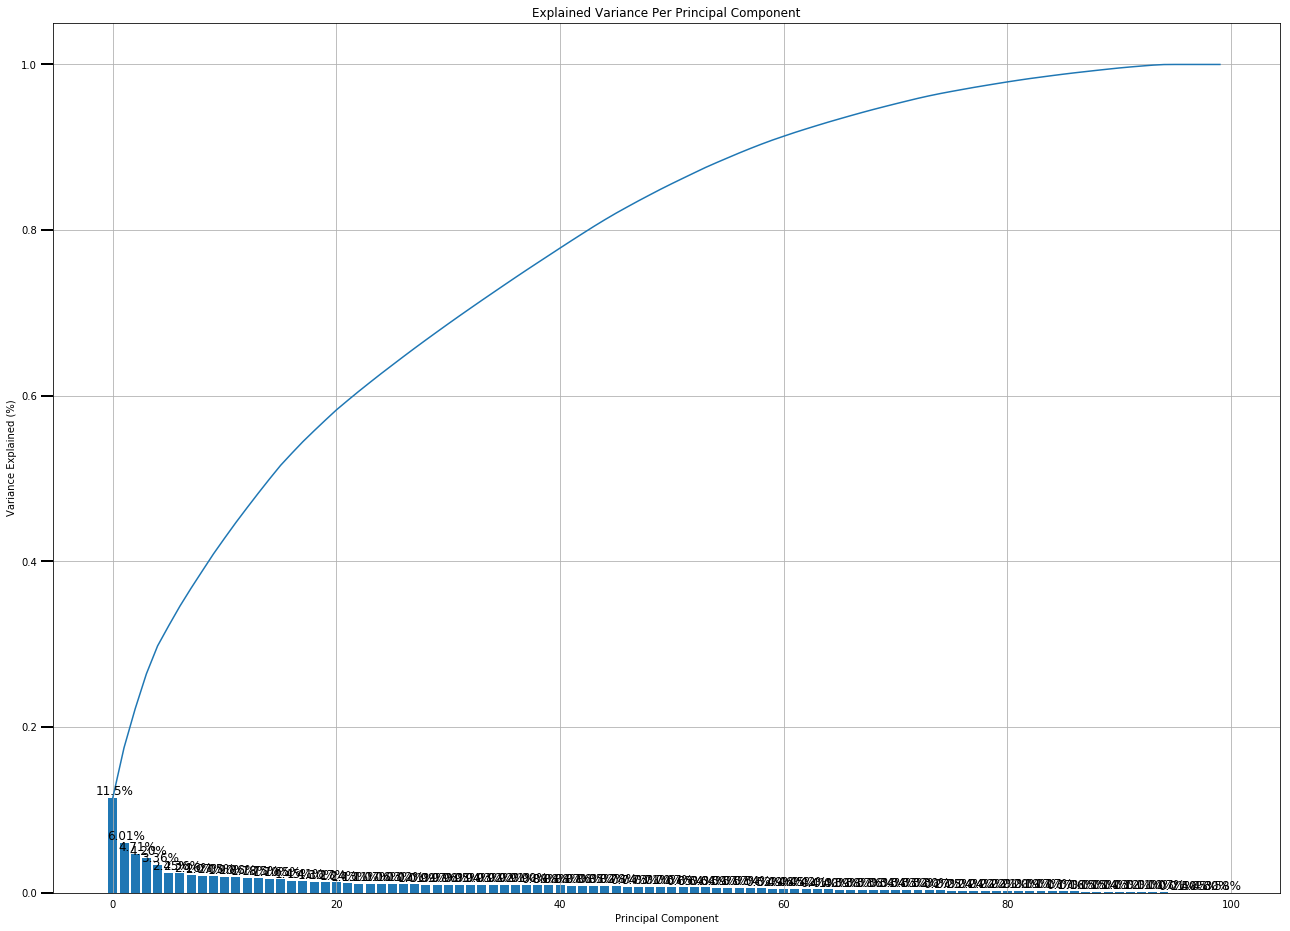

In [47]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components

    INPUT: pca - the result of instantian of PCA in scikit learn

    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_

    plt.figure(figsize=(22, 16))
    plt.grid(True)
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i] * 100)[:4])), (ind[i] + 0.2, vals[i]), va="bottom",
                    ha="center", fontsize=12)

    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)

    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca)


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


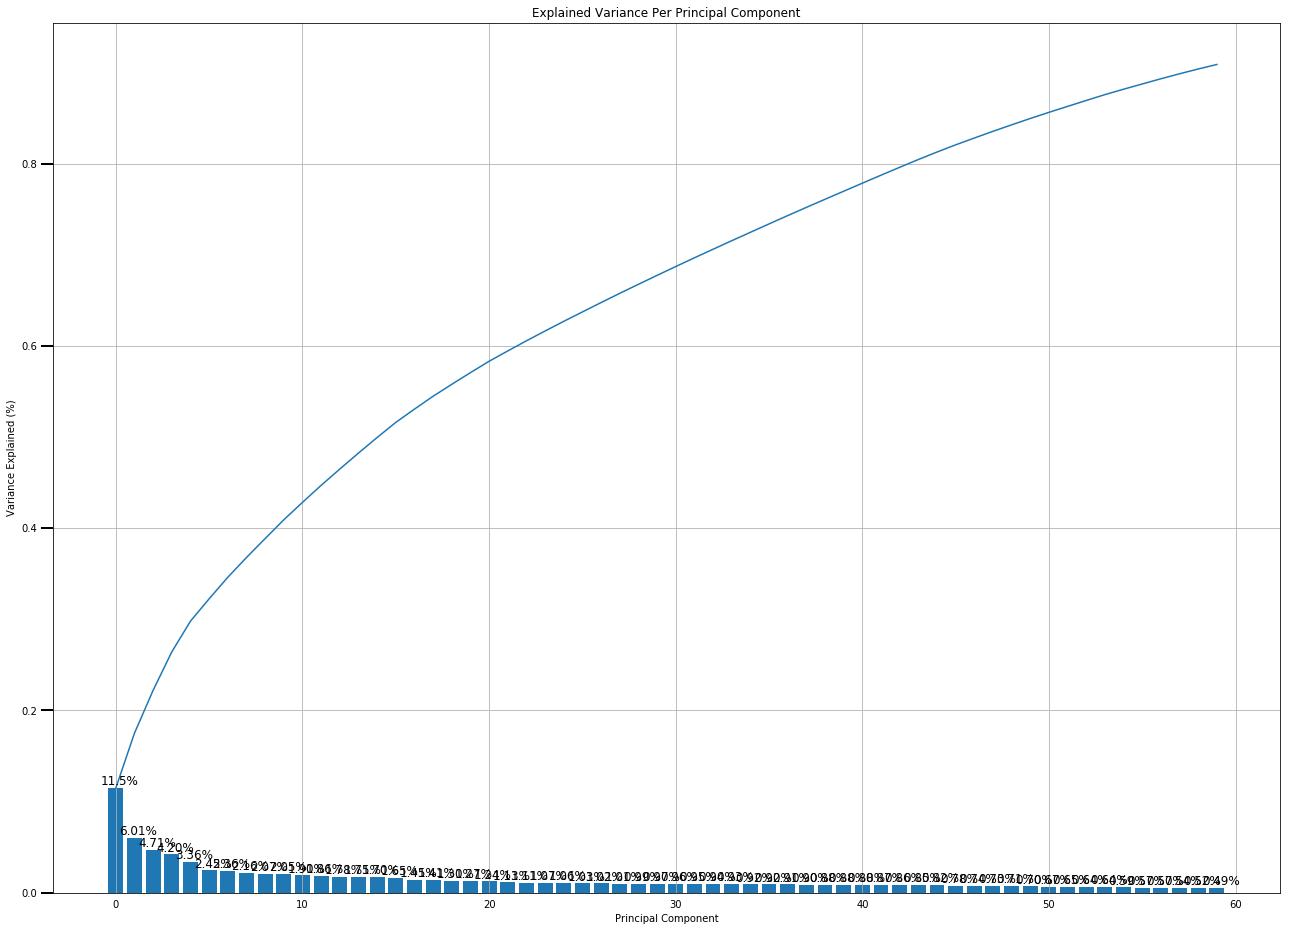

In [48]:
# Re-apply PCA to the data while selecting for number of components to retain.
#looks like that 60 PCA would capture almost 90% of the variances in the data

pca = PCA(60)
azdias_standardized_PCA60 = pca.fit_transform(azdias_standardized)
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

Based on the last two plots I decided to retain 60 PCA components (out of all 114), since it keeps almost 90 percent of the variability in the data

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [54]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_col_weights(pca,df,pca_num):
    df_col=pca_num-1;
    df_weights=pd.DataFrame(data=pca.components_,columns=df.columns);
    df_weights_sorted=df_weights.head(pca_num).T.sort_values(by=df_col,ascending=False);
    # print(df_weights_sorted.iloc[:,df_col])
    plt.figure(figsize=(22, 16))
    pd.concat([df_weights_sorted.head(),df_weights_sorted.tail()]).plot.bar();
    return df_weights_sorted.iloc[:,df_col];


LP_STATUS_GROB_1.0       0.212802
PLZ8_ANTG3               0.206500
HH_EINKOMMEN_SCORE       0.201134
PLZ8_ANTG4               0.200764
houshold_level           0.197098
ORTSGR_KLS9              0.178794
EWDICHTE                 0.177787
LP_STATUS_FEIN_1.0       0.174488
KBA05_ANTG4              0.148731
PLZ8_ANTG2               0.139030
ANZ_HAUSHALTE_AKTIV      0.132715
ARBEIT                   0.130898
KBA05_ANTG3              0.130187
RELAT_AB                 0.123599
GREEN_AVANTGARDE_0       0.120515
FINANZ_HAUSBAUER         0.119259
LP_FAMILIE_GROB_1.0      0.107431
LP_FAMILIE_FEIN_1.0      0.107431
REGIOTYP                 0.089091
LP_STATUS_FEIN_2.0       0.082095
SEMIO_PFLICHT            0.074663
KKK                      0.066113
SEMIO_REL                0.062770
W_KEIT_KIND_HH           0.061637
GFK_URLAUBERTYP_12.0     0.060096
SEMIO_KULT               0.052310
SEMIO_FAM                0.051664
OST_WEST_KZ_0.0          0.046669
generation               0.045790
SEMIO_SOZ     

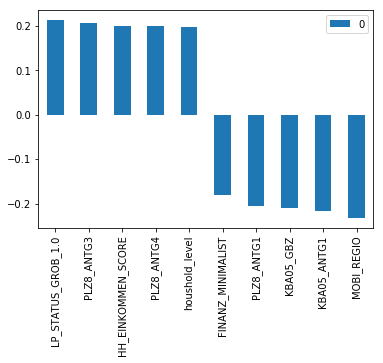

In [55]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_col_weights(pca,azdias_,1)


GREEN_AVANTGARDE_1       0.319804
mainstream_avantgarde    0.319804
LP_STATUS_GROB_5.0       0.257193
LP_STATUS_FEIN_10.0      0.257193
ORTSGR_KLS9              0.208954
EWDICHTE                 0.206908
ANZ_PERSONEN             0.141157
ONLINE_AFFINITAET        0.131414
PLZ8_ANTG3               0.116342
LP_FAMILIE_GROB_5.0      0.113099
PLZ8_ANTG4               0.106002
RELAT_AB                 0.099428
PLZ8_ANTG2               0.091669
ARBEIT                   0.086214
ALTER_HH                 0.078322
LP_FAMILIE_FEIN_10.0     0.075091
LP_FAMILIE_FEIN_11.0     0.074365
PLZ8_HHZ                 0.071636
LP_STATUS_FEIN_3.0       0.068735
LP_FAMILIE_GROB_4.0      0.065060
LP_STATUS_GROB_3.0       0.056242
SEMIO_SOZ                0.054984
SEMIO_VERT               0.053624
LP_FAMILIE_FEIN_8.0      0.051383
SEMIO_REL                0.050049
SEMIO_FAM                0.049936
SEMIO_TRADV              0.049031
LP_STATUS_FEIN_7.0       0.048661
CJT_GESAMTTYP_6.0        0.046346
generation    

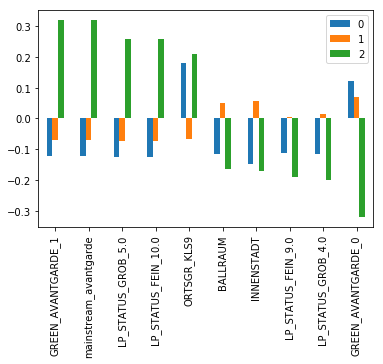

In [51]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_col_weights(pca,azdias_,3)

### Discussion 2.3: Interpret Principal Components
- The strongest positive feature weights: LP_STATUS_GROB_1.0 which is "low-income earners "


- The strongest negative feature weights: GREEN_AVANTGARDE_0 which is "not a member of green avantgarde"

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [56]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
from sklearn.cluster import KMeans

def get_kmeans_score(data, center):
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

    

Text(0.5,1,'SSE vs. K')

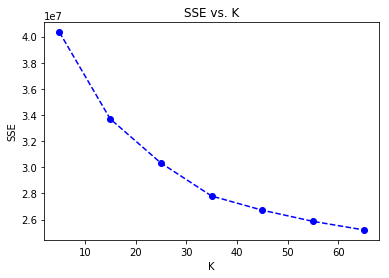

In [57]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

scores = []
centers = list(range(5,70,10))

for center in centers:
    scores.append(get_kmeans_score(azdias_standardized_PCA60, center))

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K')

Text(0.5,1,'SSE vs. K')

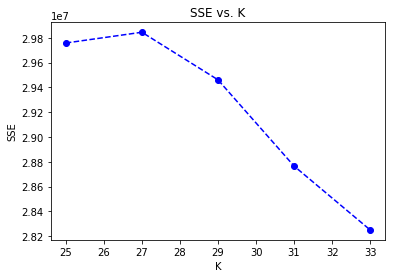

In [58]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

scores = []
centers = list(range(25,35,2))

for center in centers:
    scores.append(get_kmeans_score(azdias_standardized_PCA60, center))

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K')

In [60]:
# I will select 25 number of clusters
kmeans = KMeans(25).fit(azdias_standardized_PCA60)


In [61]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_labels4general = kmeans.predict(azdias_standardized_PCA60)

### Discussion 3.1: Apply Clustering to General Population

according to the two previous plots the first elbow plot with big step size shows that after almost 25 there is not much improvement in the clustering since it is improved slightly by adding to cluyster numbers. since the step size is 10 I focused on the interval in the second plot, from 25 to 30 to investigate it further with smaller step size, and it turns out that 25 cluster number is a good choiuce afterwhich we wont achieve significantly better results by increasing the cluster numbers.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [64]:
# Load in the customer demographics data.
# customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
# customers_processed  = clean_data(df)
customers_processed = pd.read_csv('customers_processed.csv', sep=';')#this is the outcome of last 2 commented lines


In [65]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_standardized = scaler.transform(customers_processed)
customers_standardized_PCA60= pca.fit_transform(customers_standardized)
kmeans_labels4customers = kmeans.predict(customers_standardized_PCA60)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

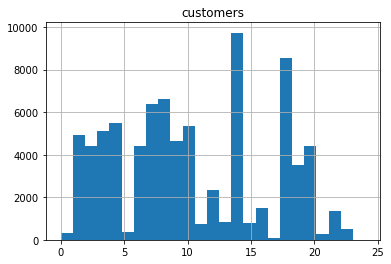

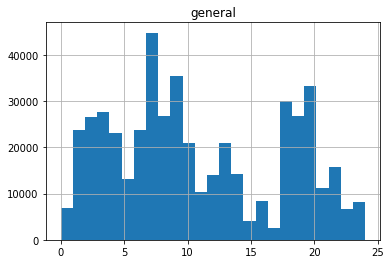

In [74]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
df_=pd.DataFrame({'customers':kmeans_labels4customers}).hist(bins=25)
df_=pd.DataFrame({'general':kmeans_labels4general}).hist(bins=25)

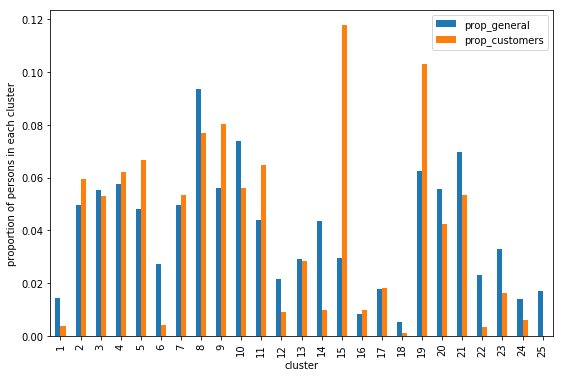

In [66]:


# Proportions for general data
general_prop = []
customers_prop = []
x = [i+1 for i in range(25)]
for i in range(25):
    general_prop.append((kmeans_labels4general == i).sum()/len(kmeans_labels4general))
    customers_prop.append((kmeans_labels4customers == i).sum()/len(kmeans_labels4customers))

plt.fig()
df_ = pd.DataFrame({'cluster' : x, 'prop_general' : general_prop, 'prop_customers':customers_prop})

#ax = sns.countplot(x='index', y = df_general['prop_1', 'prop_2'], data=df_general )
df_.plot(x='cluster', y = ['prop_general', 'prop_customers'], kind='bar', figsize=(9,6))
plt.ylabel('proportion of persons in each cluster')
plt.show()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4100f2748>]], dtype=object)

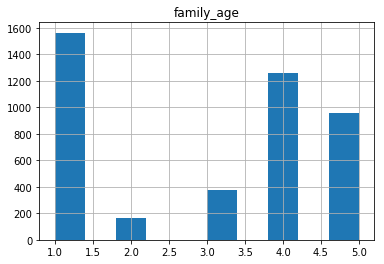

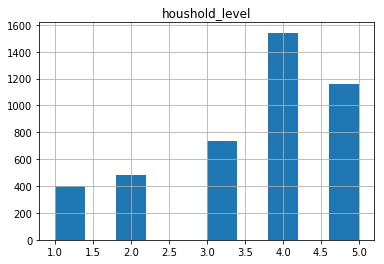

In [82]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

customers_processed['clusternom']=kmeans_labels4customers
customers_processed_clusters_15_19=customers_processed[(customers_processed['clusternom']==15) | (customers_processed['clusternom']==19)]

customers_processed_clusters_15_19.filter(like='age').hist()
customers_processed_clusters_15_19.filter(like='level').hist()
#young(1) couples with almost poor (4) level of houshold, litterally :
#Less Affluent Households - Pre-Family Couples & Singles

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff41803deb8>]], dtype=object)

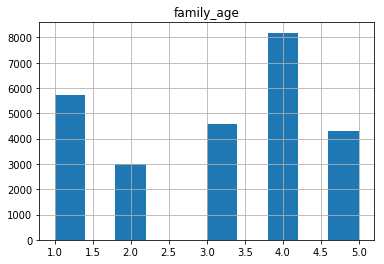

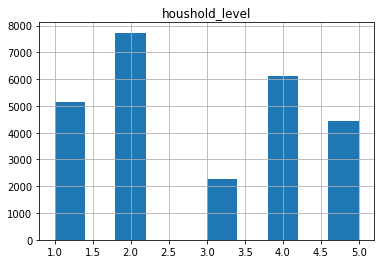

In [85]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

customers_processed['clusternom']=kmeans_labels4customers
customers_processed_clusters_1_6_8_14=customers_processed[(customers_processed['clusternom']==1) | (customers_processed['clusternom']==6)|(customers_processed['clusternom']==8) | (customers_processed['clusternom']==14)]

customers_processed_clusters_1_6_8_14.filter(like='age').hist()
customers_processed_clusters_1_6_8_14.filter(like='level').hist()
#family age 4 and houshold level 2

### Discussion 3.3: Compare Customer Data to Demographics Data

right of the bat by comparing bar plot for customers and general data, we can see clearly a good match between these two. Consider that we removed many columns and mappings without having clear idea about their concept, yet still end up with good results. Considering few over and under presented cases , that could be corrolated to the certain groups, the company should use the model. Having said that there are some overpresented and underpresented groups that we need to be more cautios about them. For example, overrepresented in the over presented customer data compared to the general population looks like are under the lables of young(1) couples with almost poor (4) level of houshold, litterally :"Less Affluent Households - Pre-Family Couples & Singles". from the other hand the under presented ones dominantely are belong to family age 4 and houshold level 2. These are based on last for plots.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.